# Single Dummy Estimates

This tutorial shows the use of a neural network to estimate the number of tricks which will be taken on a given open lead in a given contract (single dummy)

In this tutorial we'll access a bit lower-level APIs.


In [11]:
import sys
sys.path.append('../../src')

import numpy as np
import matplotlib.pyplot as plt

import scoring
import deck52

from nn.models import Models
from bidding import bidding
from bidding.binary import parse_hand_f
from bots import BotBid
from objects import Card
from util import hand_to_str
from sample import Sample
import conf

np.set_printoptions(precision=2, suppress=True, linewidth=200)
np.random.seed(42)


In [12]:
models = Models.from_conf(conf.load('../Conf/UCBC2024.conf'),'..')   # loading neural networks
sampler = Sample.from_conf(conf.load('../Conf/UCBC2024.conf'), False)  # Load sampling strategies
print(models.lead_included)

INFO:tensorflow:Restoring parameters from ..\Models/NS1EW2-bidding-3233000
INFO:tensorflow:Restoring parameters from ..\Models/NS1EW2-binfo-808000
INFO:tensorflow:Restoring parameters from ..\Models/lead_suit-154000
INFO:tensorflow:Restoring parameters from ..\Models/lead_nt-59000
INFO:tensorflow:Restoring parameters from ..\Models/single_dummy-1562000
INFO:tensorflow:Restoring parameters from ..\Models/lefty-1000000
INFO:tensorflow:Restoring parameters from ..\Models/dummy-920000
INFO:tensorflow:Restoring parameters from ..\Models/righty-1000000
INFO:tensorflow:Restoring parameters from ..\Models/decl-1000000
False


In [13]:
# helper functions are defined here. it's ok to scroll over this part

# this is the function which does the prediction
# for each possible number of tricks (from 0 to 13) 
# it returns the probability that that number of tricks will be taken (single dummy)
def single_dummy(model, hands, decl_i, strain_i, lead_card_i):
    # an array, which is the input for the neural network, is prepared
    X_sd = np.zeros((hands.shape[0], 32 + 5 + 4*32))
    X_sd[:,32 + strain_i] = 1
    X_sd[:,(32 + 5 + 0*32):(32 + 5 + 1*32)] = hands[:, (decl_i + 1) % 4]
    X_sd[:,(32 + 5 + 1*32):(32 + 5 + 2*32)] = hands[:, (decl_i + 2) % 4]
    X_sd[:,(32 + 5 + 2*32):(32 + 5 + 3*32)] = hands[:, (decl_i + 3) % 4]
    X_sd[:,(32 + 5 + 3*32):] = hands[:, decl_i]
    X_sd[:, lead_card_i] = 1
    
    return model(X_sd)

def single_dummy_without_lead(model, hands, decl_i, strain_i):
    # an array, which is the input for the neural network, is prepared
    offset = 0
    X_sd = np.zeros((hands.shape[0], offset +  5 + 4*32))
    if strain_i == 0:
        X_sd[:, strain_i] = 10
    else:
        X_sd[:, strain_i] = 1
    X_sd[:,(offset + 5 + 0*32):(offset + 5 + 1*32)] = hands[:, (decl_i + 1) % 4]
    X_sd[:,(offset + 5 + 1*32):(offset + 5 + 2*32)] = hands[:, (decl_i + 2) % 4]
    X_sd[:,(offset + 5 + 2*32):(offset + 5 + 3*32)] = hands[:, (decl_i + 3) % 4]
    X_sd[:,(offset + 5 + 3*32):] = hands[:, decl_i]
    
    return model(X_sd)

# plotting the trick probability distribution
def plot_tricks(tricks_softmax):
    tricks = tricks_softmax[0]
    plt.bar(range(14), tricks)
    plt.title(f'E(tricks) = {tricks @ np.arange(14)}')
    plt.xlabel('# tricks')
    plt.ylabel('probability')

def expected_score(tricks_softmax, contract, vuln):
    tricks = tricks_softmax
    score_by_tricks = np.array([scoring.score(contract, vuln, i) for i in range(14)])
    return tricks @ score_by_tricks

In [14]:
# we take the following hand as an example
# West plays it in 3N on a small heart lead
# how many tricks will declarer take?

hands_str = 'AT9xx.x.T98xx.Ax KQxx.9.Ax.K98xxx J8x.AJxxxx.Kx.xx x.KQT8x.QJxx.QJT'  # N E S W
contract = '3CS'
opening_lead = 'CA'

In [15]:
# this line just converts the string representation of the hands into a binary format
hands = np.vstack([parse_hand_f(32)(s) for s in hands_str.split()]).reshape((-1, 4, 32))

print(hands)
# applying the function which does the prediction
if models.lead_included:
    tricks_distr = single_dummy(
        models.sd_model.model, 
        hands, 
        decl_i='NESW'.index(contract[-1]), 
        strain_i='NSHDC'.index(contract[1]), 
        lead_card_i=deck52.card52to32(Card.from_symbol(opening_lead).code()),
    )
else:
    tricks_distr = single_dummy_without_lead(
        models.sd_model.model, 
        hands, 
        decl_i='NESW'.index(contract[-1]), 
        strain_i='NSHDC'.index(contract[1])
    )


[[[1 0 0 0 1 1 0 2 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 2 1 0 0 0 0 0 0 1]
  [0 1 1 0 0 0 0 2 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 3]
  [0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 4 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 2]
  [0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 2 0 0 1 1 1 0 0 0]]]


In [16]:
# the result is an array representing the probability distribution of tricks

# the first element of the array is the probability that declarer will take 0 tricks
# the last element of the array is the probability that declarer will take 13 tricks
tricks_distr

array([[0.  , 0.04, 0.38, 0.4 , 0.17, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]], dtype=float32)

In [17]:
# Get the indices of the top three probabilities
probabilities = tricks_distr.flatten()
top_indices = np.argsort(tricks_distr.flatten())[-3:]

# Get the top three probabilities
top_probs = probabilities[top_indices]

# Normalize the top probabilities to sum up to 1.0 (or 100%)
normalized_probs = top_probs / np.sum(top_probs)

# Reconstruct the array with updated probabilities
result_array = np.zeros_like(probabilities)
result_array[top_indices] = normalized_probs

# Reshape the result to match the original shape
result_array = result_array.reshape((1, -1))

print("Resulting array with updated top three probabilities and zeros for the rest:")
print(result_array)


Resulting array with updated top three probabilities and zeros for the rest:
[[0.   0.   0.4  0.42 0.18 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


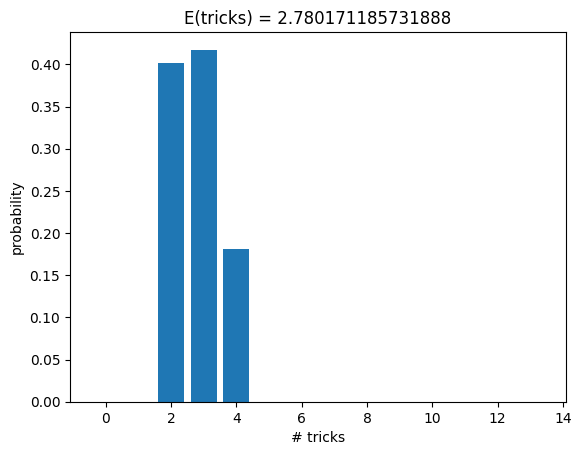

In [18]:
# we can also plot it to see it better
plot_tricks(result_array)

In [19]:
# we can also compute how much declarer is expected to score on this hand (non-vulnerable)
expected_score(result_array, contract='5HX', vuln=False)[0]

-2065.9487307071686

In [20]:
# or we can get the probability that the contract will be made (i.e declarer will take 12 or more tricks)
np.sum(result_array[:,11:])

0.0